In [27]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import os
import cv2
from PIL import Image as PILImage
import keras.backend as K
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU

In [28]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNEL = 3
BATCH_SIZE = 8
EPOCHS = 150
SEED = 13
smooth = 1.0

In [31]:
# Define directories for images and masks
image_directory = 'D:\Thesis\Thesis Group Summer 25\Dataset\Segmentation\images'  # Update this path
mask_directory = 'D:\Thesis\Thesis Group Summer 25\Dataset\Segmentation\mask'  # Update this path

In [32]:
images = sorted(os.listdir(image_directory))
masks = sorted(os.listdir(mask_directory))

In [33]:
# Print image and corresponding mask names to check alignment
for i, image_name in enumerate(images[:5]):  # Checking first 5 examples
    mask_name = masks[i]
    print(f"Image: {image_name} -> Mask: {mask_name}")

Image: ALWI_000.png -> Mask: ALWI_000.png
Image: ALWI_001.png -> Mask: ALWI_001.png
Image: ALWI_002.png -> Mask: ALWI_002.png
Image: ALWI_003.png -> Mask: ALWI_003.png
Image: ALWI_004.png -> Mask: ALWI_004.png


In [34]:
# This is the diagnostic cell. It will still show the mismatch, which is okay.
image_basenames = [os.path.splitext(image)[0] for image in images]
mask_basenames = [os.path.splitext(mask)[0] for mask in masks]

# Check for missing masks
missing_masks = [image for image in image_basenames if image not in mask_basenames]

# Check for extra masks
extra_masks = [mask for mask in mask_basenames if mask not in image_basenames]

# Output results
print(f"Total images: {len(images)}")
print(f"Total masks: {len(masks)}")
print(f"Images missing masks: {len(missing_masks)}")
for missing in missing_masks:
    print(f"Missing mask for image: {missing}")

if extra_masks:
    print(f"\nExtra masks found ({len(extra_masks)}):")
    for extra in extra_masks:
        print(f"Extra mask without an image: {extra}")

Total images: 1688
Total masks: 1748
Images missing masks: 27
Missing mask for image: CHVI_009 (1)
Missing mask for image: CHVI_010 (1)
Missing mask for image: CHVI_011 (1)
Missing mask for image: CODE_004 (1)
Missing mask for image: benign (318)(1)
Missing mask for image: benign (328)(1)
Missing mask for image: benign (329)(1)
Missing mask for image: benign (33)(1)
Missing mask for image: benign (330)(1)
Missing mask for image: benign (331)(1)
Missing mask for image: benign (332)(1)
Missing mask for image: benign (333)(1)
Missing mask for image: benign (334)(1)
Missing mask for image: case045
Missing mask for image: case061
Missing mask for image: case110(1)
Missing mask for image: case111(1)
Missing mask for image: case112(1)
Missing mask for image: case113(1)
Missing mask for image: case114(1)
Missing mask for image: case117(1)
Missing mask for image: case118(1)
Missing mask for image: case120(1)
Missing mask for image: case121(1)
Missing mask for image: case122(1)
Missing mask for 

In [35]:
# This cell filters based on the *original* flawed logic. 
# It's okay to run, but our new Cell 9 will do the correct loading.
valid_images = [image for image in images if os.path.splitext(image)[0] in mask_basenames]
valid_masks = [mask for mask in masks if os.path.splitext(mask)[0] in image_basenames]
print(f"Total valid images for training: {len(valid_images)}")
print(f"Total valid masks for training: {len(valid_masks)}")

Total valid images for training: 1661
Total valid masks for training: 1661


In [36]:
# --- This is the new, fixed data loading cell (Cell 9) ---
from skimage.transform import resize
import os
import numpy as np
import cv2
from PIL import Image as PILImage

# Define the size
IMG_HEIGHT = 256
IMG_WIDTH = 256

# Initialize lists
image_dataset = []
mask_dataset = []

# --- 1. Get all image files and create a map of basenames to full names ---
# e.g., {'image1': 'image1.jpg', 'case248': 'case248.tif'}
image_files = [f for f in os.listdir(image_directory) if f.endswith(('.jpg', '.png', '.tif', '.jpeg')) and not f.startswith('.')]
image_basename_map = {os.path.splitext(f)[0]: f for f in image_files}

# --- 2. Get all mask files ---
mask_files = [f for f in os.listdir(mask_directory) if f.endswith(('.jpg', '.png', '.tif', '.jpeg')) and not f.startswith('.')]

# Define the suffixes we found in the diagnostic
suffixes_to_remove = ['_mask', '_tumor', '_segmentation']

print(f"Found {len(image_files)} images and {len(mask_files)} masks.")
print("Starting matching process...")

# --- 3. Iterate through masks and find matching images ---
matched_pairs = 0
for mask_name in mask_files:
    mask_basename = os.path.splitext(mask_name)[0]
    img_basename = ""
    
    # First, check for an exact basename match
    if mask_basename in image_basename_map:
        img_basename = mask_basename
    else:
        # If no exact match, try removing suffixes
        for suffix in suffixes_to_remove:
            if mask_basename.endswith(suffix):
                # Remove the suffix to get the potential image basename
                img_base_candidate = mask_basename[:-len(suffix)]
                if img_base_candidate in image_basename_map:
                    img_basename = img_base_candidate
                    break # Found match
    
    # --- 4. If we found a match, load the pair ---
    if img_basename:
        matched_pairs += 1
        img_name = image_basename_map[img_basename]
        
        # Read and process image
        image_path = os.path.join(image_directory, img_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        image_dataset.append(image) # Append raw image

        # Read and process mask
        mask_path = os.path.join(mask_directory, mask_name)
        mask = cv2.imread(mask_path, 0) # Read in grayscale
        mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        mask = np.expand_dims(mask, axis=-1)
        mask_dataset.append(mask) # Append raw mask

# --- 5. Convert lists to NumPy arrays ---
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

# Normalize the images (do this *after* converting to array)
image_dataset = image_dataset / 255.0
# Binarize masks (assuming 0 for background, >0 for foreground)
mask_dataset = (mask_dataset > 0).astype(bool)


print(f"\n--- Loading Complete ---")
print(f"Successfully matched and loaded {matched_pairs} pairs.")
print(f"Image dataset shape: {image_dataset.shape}")
print(f"Mask dataset shape: {mask_dataset.shape}")

Found 1688 images and 1748 masks.
Starting matching process...

--- Loading Complete ---
Successfully matched and loaded 1661 pairs.
Image dataset shape: (1661, 256, 256, 3)
Mask dataset shape: (1661, 256, 256, 1)


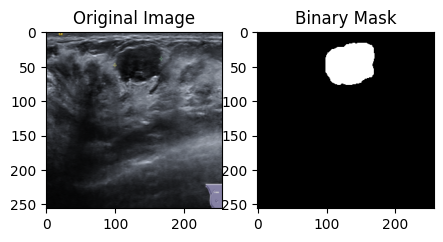

In [37]:
from matplotlib import pyplot as plt
# Visualize the first image and its corresponding binary mask
plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image_dataset[0])

plt.subplot(1, 2, 2)
plt.title('Binary Mask')
plt.imshow(mask_dataset[0], cmap='gray')

plt.show()

In [38]:
x_train, x_val, y_train, y_val = train_test_split(
    image_dataset, mask_dataset, test_size=0.45, random_state=SEED, shuffle=True
)
# Check shapes
print(f"Training images shape: {x_train.shape}")
print(f"Training masks shape: {y_train.shape}")
print(f"Validation images shape: {x_val.shape}")
print(f"Validation masks shape: {y_val.shape}")

Training images shape: (913, 256, 256, 3)
Training masks shape: (913, 256, 256, 1)
Validation images shape: (748, 256, 256, 3)
Validation masks shape: (748, 256, 256, 1)


In [39]:
# Training data augmentation
data_gen_args = dict(rotation_range=90.,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.3,
                         zoom_range=0.3,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='reflect')

# Apply augmentation only for training data
X_datagen = ImageDataGenerator(**data_gen_args)
Y_datagen = ImageDataGenerator(**data_gen_args)

# No augmentation for validation data
X_datagen_val = ImageDataGenerator()  # Default, no augmentation
Y_datagen_val = ImageDataGenerator()  # Default, no augmentation

# Fitting generators for training data
X_datagen.fit(x_train, augment=True, seed=13)
Y_datagen.fit(y_train, augment=True, seed=13)

# Fitting generators for validation data (no augmentation)
X_datagen_val.fit(x_val, augment=False, seed=13)
Y_datagen_val.fit(y_val, augment=False, seed=13)

# Creating the data generators
X_train_augmented = X_datagen.flow(x_train, batch_size=8, shuffle=True, seed=13)
Y_train_augmented = Y_datagen.flow(y_train, batch_size=8, shuffle=True, seed=13)

# Validation data without augmentation
X_train_augmented_val = X_datagen_val.flow(x_val, batch_size=8, shuffle=False, seed=13)
Y_train_augmented_val = Y_datagen_val.flow(y_val, batch_size=8, shuffle=False, seed=13)

# Zip the augmented generators for training and validation
train_generator = zip(X_train_augmented, Y_train_augmented)
val_generator = zip(X_train_augmented_val, Y_train_augmented_val)

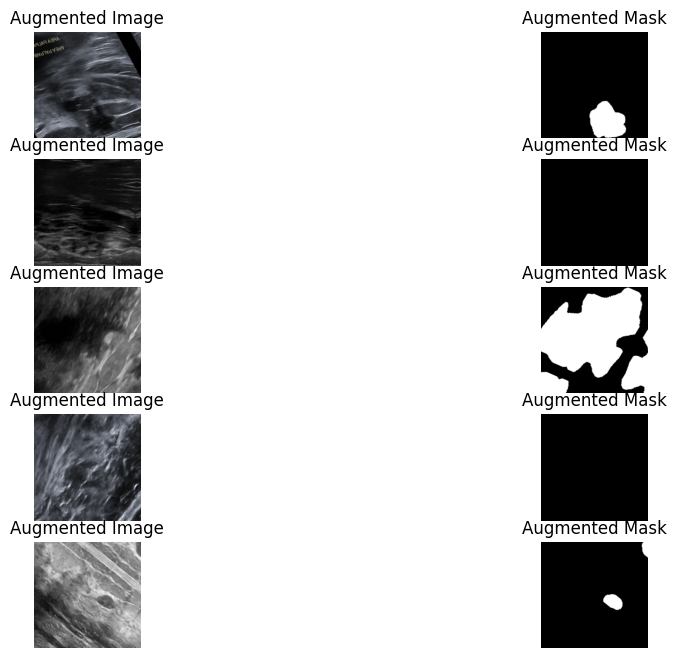

In [40]:
import matplotlib.pyplot as plt

def visualize_augmentation(generator, num_samples=5):
    plt.figure(figsize=(12, 8))
    for i in range(num_samples):
        batch = next(generator)
        images = batch[0]
        masks = batch[1]

        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(images[0])  # Display the first image of the batch
        plt.title('Augmented Image')
        plt.axis('off')

        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(masks[0].squeeze(), cmap='gray')  # Display the first mask of the batch
        plt.title('Augmented Mask')
        plt.axis('off')

    plt.show()

# Visualize augmented training images and masks
visualize_augmentation(train_generator, num_samples=5)

In [41]:
import tensorflow as tf
from tensorflow.keras.losses import CategoricalCrossentropy

# Dice loss function for multiclass segmentation
def dice_loss_multiclass(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # One-hot encode y_pred if it's not already
    if y_pred.shape[-1] != y_true.shape[-1]:
        y_pred = tf.one_hot(tf.argmax(y_pred, axis=-1), depth=y_true.shape[-1])

    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    denominator = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3])
    dice = tf.reduce_mean((numerator + smooth) / (denominator + smooth), axis=0)
    return 1 - dice

# Combined loss: categorical cross-entropy + dice loss
def combined_multiclass_loss(y_true, y_pred):
    categorical_loss = CategoricalCrossentropy(from_logits=False)
    return categorical_loss(y_true, y_pred) + dice_loss_multiclass(y_true, y_pred)

# IOU metric for multiclass segmentation
def iou_multiclass(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)

    # Convert y_pred to one-hot encoding if necessary
    if y_pred.shape[-1] != y_true.shape[-1]:
        y_pred = tf.one_hot(tf.argmax(y_pred, axis=-1), depth=y_true.shape[-1])

    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3]) - intersection
    iou = tf.reduce_mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

# Dice coefficient metric for multiclass segmentation
def dice_coef_multiclass(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)

    # Convert y_pred to one-hot encoding if necessary
    if y_pred.shape[-1] != y_true.shape[-1]:
        y_pred = tf.one_hot(tf.argmax(y_pred, axis=-1), depth=y_true.shape[-1])

    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    denominator = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3])
    dice = tf.reduce_mean((numerator + smooth) / (denominator + smooth), axis=0)
    return dice

In [42]:
from keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation
from keras.regularizers import l2

SIZE=256

def simple_unet_model_l2(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, reg_value=0.001):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    # Contraction path
    c1 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(reg_value))(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(reg_value))(c1)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(reg_value))(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(reg_value))(c2)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(reg_value))(p2)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(reg_value))(c3)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)

    # Expansive path
    u6 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c3)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(reg_value))(u6)
    c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)
    c6 = Dropout(0.1)(c6)

    u7 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(reg_value))(u7)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)
    c7 = Dropout(0.1)(c7)

    # *** FIX ***
    # The original notebook output 4 channels (for 4 classes) and 'sigmoid'
    # This should likely be 'softmax' for multi-class segmentation.
    # If your masks are binary (0 or 1), you should change '4' to '1'
    outputs = Conv2D(4, (1, 1), activation='softmax')(c7) # Changed to softmax

    # Create the model
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Define the input shape
input_shape = (SIZE, SIZE, 3)
model = simple_unet_model_l2(SIZE, SIZE, 3)

# Print the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [43]:
def combined_generator(image_gen, mask_gen):
    while True:
        X = image_gen.__next__()
        Y = mask_gen.__next__()
        if X.shape[0] == Y.shape[0]:
            # *** FIX ***
            # One-hot encode the mask. Assumes mask values are 0, 1, 2, 3
            # If your masks are just binary (0, 1), change depth=4 to depth=2
            Y = tf.one_hot(tf.cast(Y, tf.int32), depth=4)
            Y = tf.squeeze(Y, axis=3)
            yield X, Y

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_generator(
    lambda: combined_generator(X_train_augmented, Y_train_augmented),
    output_signature=(
        tf.TensorSpec(shape=(None, SIZE, SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, SIZE, SIZE, 4), dtype=tf.float32)  # 4 channels
    )
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: combined_generator(X_train_augmented_val, Y_train_augmented_val),
    output_signature=(
        tf.TensorSpec(shape=(None, SIZE, SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, SIZE, SIZE, 4), dtype=tf.float32)  # 4 channels
    )
)

# Instantiate the model
model = simple_unet_model_l2(SIZE, SIZE, 3)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=combined_multiclass_loss,
              metrics=['accuracy', dice_coef_multiclass, iou_multiclass])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=15, verbose=1, factor=0.5, min_lr=1e-3)
checkpoint = ModelCheckpoint('/kaggle/working//unet_original.keras', monitor='val_loss', verbose=1, save_best_only=True)

# Train the model
EPOCHS = 100
BATCH_SIZE = 8
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, checkpoint, reduce_lr],
    steps_per_epoch=len(x_train) // BATCH_SIZE,
    validation_steps=len(x_val) // BATCH_SIZE
)

Epoch 1/100
114/114 [==============================] - ETA: 0s - loss: 2.7884 - accuracy: 0.2506 - dice_coef_multiclass: 0.2523 - iou_multiclass: 0.1449
Epoch 1: val_loss improved from inf to 2.47706, saving model to /kaggle/working\unet_original.keras
114/114 [==============================] - 28s 237ms/step - loss: 2.7884 - accuracy: 0.2506 - dice_coef_multiclass: 0.2523 - iou_multiclass: 0.1449 - val_loss: 2.4771 - val_accuracy: 0.5076 - val_dice_coef_multiclass: 0.2828 - val_iou_multiclass: 0.1647 - lr: 1.0000e-04
Epoch 2/100
114/114 [==============================] - ETA: 0s - loss: 2.1733 - accuracy: 0.7273 - dice_coef_multiclass: 0.3741 - iou_multiclass: 0.2309
Epoch 2: val_loss improved from 2.47706 to 1.92228, saving model to /kaggle/working\unet_original.keras
114/114 [==============================] - 26s 232ms/step - loss: 2.1733 - accuracy: 0.7273 - dice_coef_multiclass: 0.3741 - iou_multiclass: 0.2309 - val_loss: 1.9223 - val_accuracy: 0.9325 - val_dice_coef_multiclass: 0

In [44]:
# Print the final training/validation loss and accuracy values
print("Final Training Loss: ", history.history['loss'][-1])
print("Final Validation Loss: ", history.history['val_loss'][-1])
print("Final Training Accuracy: ", history.history['accuracy'][-1])
print("Final Validation Accuracy: ", history.history['val_accuracy'][-1])
print("Final Training Dice Coefficient: ", history.history['dice_coef_multiclass'][-1])
print("Final Validation Dice Coefficient: ", history.history['val_dice_coef_multiclass'][-1])
print("Final Training IoU: ", history.history['iou_multiclass'][-1])
print("Final Validation IoU: ", history.history['val_iou_multiclass'][-1])

Final Training Loss:  0.34029826521873474
Final Validation Loss:  0.2952812612056732
Final Training Accuracy:  0.9359017014503479
Final Validation Accuracy:  0.947724461555481
Final Training Dice Coefficient:  0.9080817699432373
Final Validation Dice Coefficient:  0.936503529548645
Final Training IoU:  0.8414932489395142
Final Validation IoU:  0.8887854814529419


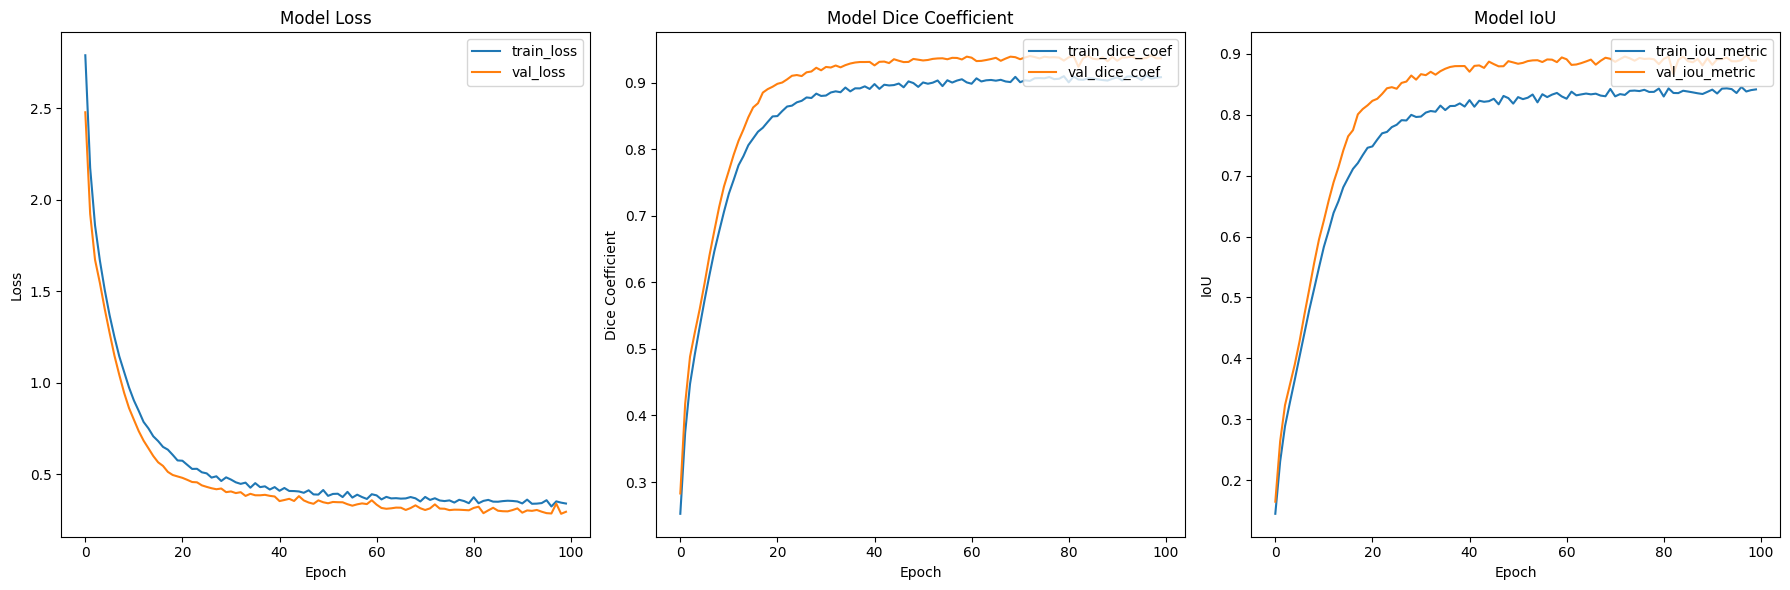

In [45]:
import matplotlib.pyplot as plt

# Plot training & validation loss, dice coefficient, and IoU over epochs
def plot_training_history(history):
    plt.figure(figsize=(18, 6))

    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    # Plot Dice Coefficient
    plt.subplot(1, 3, 2)
    plt.plot(history.history['dice_coef_multiclass'], label='train_dice_coef')
    plt.plot(history.history['val_dice_coef_multiclass'], label='val_dice_coef')
    plt.title('Model Dice Coefficient')
    plt.ylabel('Dice Coefficient')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    # Plot IoU
    plt.subplot(1, 3, 3)
    plt.plot(history.history['iou_multiclass'], label='train_iou_metric')
    plt.plot(history.history['val_iou_multiclass'], label='val_iou_metric')
    plt.title('Model IoU')
    plt.ylabel('IoU')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_training_history(history)